In [1]:
import sys
import os

sys.path.append(os.path.join('..'))

In [2]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
from src.utils.seed import set_random_seed

# Set the random seed for deterministic operations.
SEED = 42
set_random_seed(SEED)

https://github.com/LMissher/STGNN/blob/main/model.py

In [4]:
import torch

# Set the device for training and querying the model.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The selected device is: "{DEVICE}"')

The selected device is: "cuda"


Link to download the datasets: https://graphmining.ai/temporal_datasets/

DEPENDENCY Pytables

# 1 Metr-LA Dataset

ORIGINAL PAPER: https://arxiv.org/pdf/1707.01926.pdf

***Metr-LA:*** This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). We select $207$ sensors andcollect 4 months of data ranging from Mar $1^{st}$ $2012$ to Jun $30^{th}$ $2012$ for the experiment.

In both of those datasets, we aggregate traffic speed readings into 5 minutes windows.

The total number of observed traffic data points is $6,519,002$.

In [5]:
# Set the base data directory.
BASE_DATA_DIR = os.path.join('..', 'data', 'metr-la')

In [6]:
from src.data.data_extraction import get_node_values_dataframe

# Get the dataframe containing the node values at different timestamps for Metr-LA.
node_values_df = get_node_values_dataframe(
    os.path.join(BASE_DATA_DIR, 'metr-la.h5'), turn_in_kmph=True)

In [7]:
node_values_df.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
2012-03-01 00:00:00,103.601520,108.831888,108.027216,98.974656,107.624880,110.642400,104.808528,108.027216,95.957136,100.986336,...,73.426320,105.412032,103.802688,106.906423,107.624880,95.5548,111.044736,95.353632,111.044736,99.578160
2012-03-01 00:05:00,100.852224,110.329472,105.322624,100.494592,103.713280,109.614208,104.607360,104.607360,92.447872,101.925120,...,81.540096,112.452912,107.289600,94.236032,99.779328,98.3488,103.713280,89.944448,110.150656,101.187504
2012-03-01 00:10:00,102.998016,102.595680,96.560640,94.951296,107.021376,106.619040,103.802688,103.400352,102.796848,105.210864,...,71.012304,111.044736,90.927936,95.353632,109.636560,100.5840,105.613200,98.773488,112.424174,99.779328
2012-03-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
2012-03-01 00:20:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000


In [8]:
from src.data.data_extraction import get_locations_dataframe

# Get the dataframe containing the latitude and longitude of each sensor.
locations_df = get_locations_dataframe(
    os.path.join(BASE_DATA_DIR, 'graph_sensor_locations_metr_la.csv'),
    has_header=True)

In [9]:
locations_df.head()

,sensor_id,latitude,longitude
index,,,
0,773869,34.15497,-118.31829
1,767541,34.11621,-118.23799
2,767542,34.11641,-118.23819
3,717447,34.07248,-118.26772
4,717446,34.07142,-118.26572


# Data Analysis

In [10]:
BASE_CONFIG_DIR = os.path.join('..', 'config', 'kepler', 'metr-la')

In [11]:
from keplergl.keplergl import KeplerGl

In [12]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'spatial-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [13]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)
kepler_map.add_data(data=locations_df, name="Metr-LA spatial graph")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [14]:
print('Metr-LA spatial graph:')
kepler_map

Metr-LA spatial graph:


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '9hguwbd', 'type': …

# Missing Values Per-Node

In [15]:
import json

In [16]:
zeroes_per_node = {}

for c in node_values_df.columns:
    counts = (node_values_df[c] == 0.).sum()
    zeroes_per_node[c] = counts

In [17]:
locations_df_with_missing_values = locations_df.copy()
locations_df_with_missing_values['Missing Values'] = locations_df_with_missing_values.apply(
    lambda x: zeroes_per_node[x[0]], axis = 1
)


In [18]:
with open(os.path.join(BASE_CONFIG_DIR, 'total-missing-values-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [19]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=locations_df_with_missing_values, name='Metr-LA total missing values per node')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


The map visualizes the total amount of missing values per node. We can observe that peripheral zones in the west part of the map and nodes in the Glendale and Los Angeles areas experience the highest amount of missing information, in particular in presence of highway crossing zones.

In [20]:
print('Metr-LA total missing values per node:')
kepler_map

Metr-LA total missing values per node:


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5xprfeq', 'type': …

In [21]:
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}

In [22]:
import matplotlib.pyplot as plt

In [23]:
# Get the missing values count per timestamp.
missing_count = node_values_df.apply(lambda x: x == 0)

In [24]:
from src.data.data_analysis import group_dataframe_by_period

grouped_by_day_of_week = group_dataframe_by_period(
    missing_count, 'day_of_week', aggregation='sum')

In [25]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_day_of_week, locations_df, metric_name='Missing count',
    turn_datetimes_to_timestamp=False)

In [26]:
with open(os.path.join(BASE_CONFIG_DIR, 'missing-values-day-of-week-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [27]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average missing values per node per day of the week')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [28]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average missing val…

The graph illustates that the highest amount of average missing values per node is observed on Mondays and Sundays, which could possibly correspond to days where people move out or in the area for working purposes. Interestingly, during the middle of the week less missing information is observed.

It is worth noticing how the missing average information per nodes is particularly high per day, ranging between $3,000$ and $8,000$ cases.

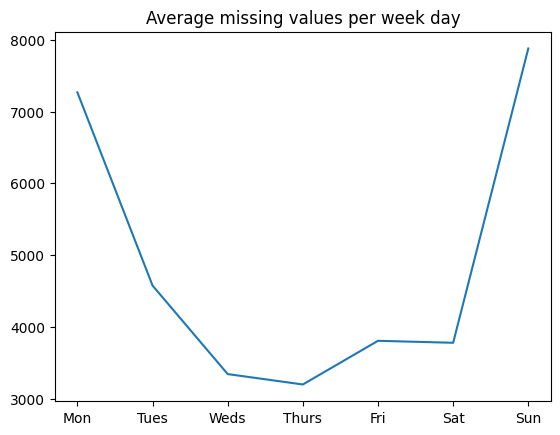

In [29]:
res = grouped_by_day_of_week.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index.map(days), res.values)
#ax.set_xticks(res.index.strftime('%Y-%m-%d')[::25])
ax.set_title('Average missing values per week day')
plt.show()

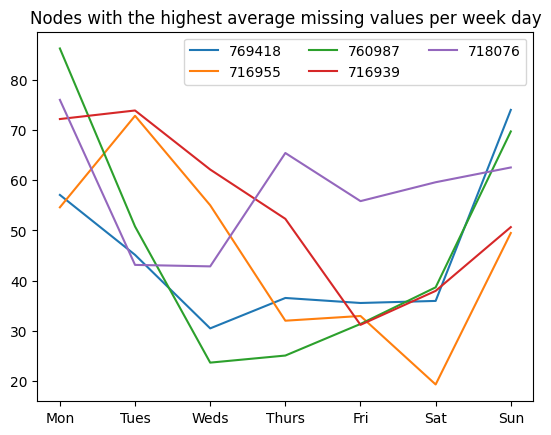

In [30]:
higest_missing_values_nodes = grouped_by_day_of_week.mean(axis=0).sort_values()[-5:]
res = grouped_by_day_of_week[higest_missing_values_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index.map(days), res.values, label=res.columns.values)
#ax.set_xticks(res.index.strftime('%Y-%m-%d')[::25])
ax.set_title('Nodes with the highest average missing values per week day')
plt.legend(ncol=3)
plt.show()

We can observe from the graph that the nodes with the highest missing values generally correspond to the ones of the highway crossings. They are present in an area around Griffith Park, in two crossings of glendale and in a central part of Los Angeles.

Across all evaluations, these nodes are always observed as the ones with the highest amount of missing values.

In [31]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(higest_missing_values_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [36, 39, 56, 105, 174], 'columns': ['sensor_id', 'latitude', 'longitude'],…

In [32]:
from src.data.data_analysis import group_dataframe_by_period

grouped_by_hour_of_day = group_dataframe_by_period(
    missing_count, 'hour_of_day', aggregation='sum')

In [33]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_hour_of_day, locations_df, metric_name='Missing count',
    turn_datetimes_to_timestamp=False)

In [34]:
import json
with open(os.path.join(BASE_CONFIG_DIR, 'missing-values-hour-of-day-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [35]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average missing values per node per hour of the day')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [36]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average missing val…

The chart makes it clear that the average amount of missing values per node during the day, although erratic, has a decreasing tendency and it hits its lowest point at $08:00$ p.m.

Peaking amount of missing values are observed at night hours, where traffic is supposed to be less. Rush hours like $10:00$ a.m., $03:00$ p.m. or $08:00$ p.m. are in correspondance of troughs in the chart.

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\1519355475.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])


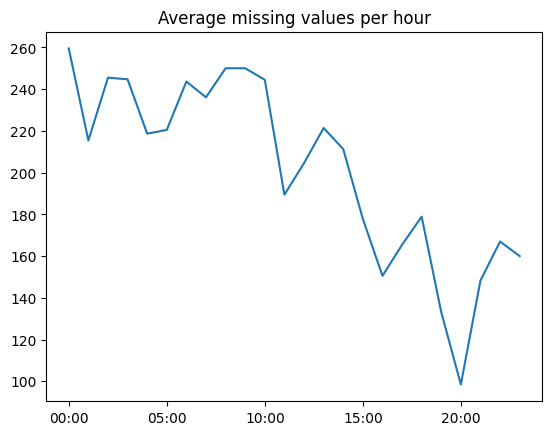

In [37]:
res = grouped_by_hour_of_day.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])
ax.set_title('Average missing values per hour')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\2028890959.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])


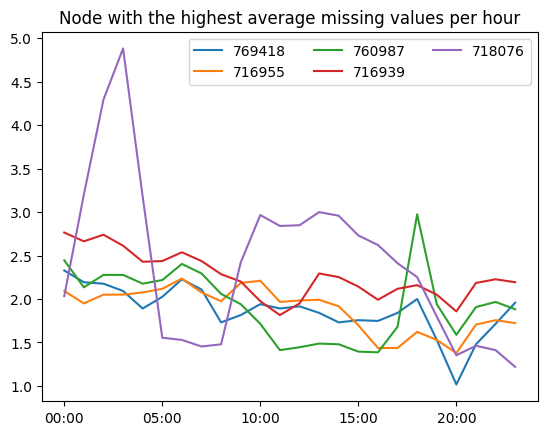

In [38]:
higest_missing_values_nodes = grouped_by_hour_of_day.mean(axis=0).sort_values()[-5:]
res = grouped_by_hour_of_day[higest_missing_values_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])
ax.set_title('Node with the highest average missing values per hour')
plt.legend(ncol=3)
plt.show()

In [39]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(higest_missing_values_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [36, 39, 56, 105, 174], 'columns': ['sensor_id', 'latitude', 'longitude'],…

In [40]:
grouped_by_week_of_the_year = group_dataframe_by_period(
    missing_count, 'week_of_year', aggregation='sum')

In [41]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_week_of_the_year, locations_df, metric_name='Missing count',
    turn_datetimes_to_timestamp=True)

In [42]:
with open(os.path.join(BASE_CONFIG_DIR, 'missing-values-week-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [43]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average missing values per node per week of the year')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [44]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average missing val…

When we observe the amount of missing values per week of the year, we can see that the high values are observed between the first weeks of March and the end of April. Peaks are seen between Mach and April and in the beginning of June.

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\2407071208.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


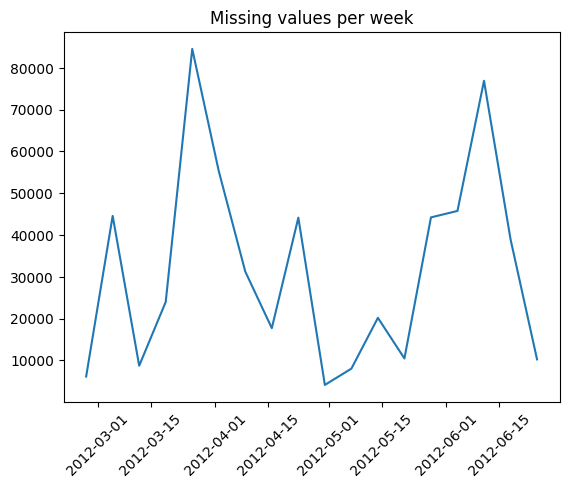

In [45]:
#grouped = grouped_by_week_of_the_year.sum()
grouped = grouped_by_week_of_the_year.groupby(
    grouped_by_week_of_the_year.index.to_timestamp())
grouped = grouped.sum()
res = grouped.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Missing values per week')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\3203620408.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


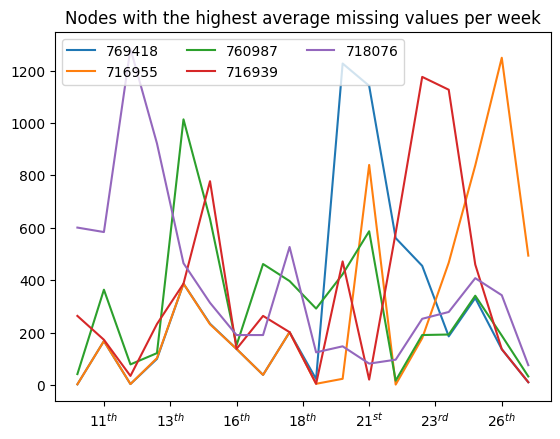

In [46]:
grouped = grouped_by_week_of_the_year.groupby(
    grouped_by_week_of_the_year.to_timestamp().index.isocalendar().week.to_list())
grouped = grouped.sum()
higest_missing_values_nodes = grouped.mean(axis=0).sort_values()[-5:]
res = grouped[higest_missing_values_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Nodes with the highest average missing values per week')
plt.legend(ncols=3)
plt.show()

In [47]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(higest_missing_values_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [36, 39, 56, 105, 174], 'columns': ['sensor_id', 'latitude', 'longitude'],…

In [48]:
grouped_by_day_of_the_year = group_dataframe_by_period(
    missing_count, 'day_of_year', aggregation='sum')

In [49]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_day_of_the_year, locations_df, metric_name='Missing count',
    turn_datetimes_to_timestamp=True)

In [50]:
import json
with open(os.path.join(BASE_CONFIG_DIR, 'missing-values-day-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [51]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average missing values per node per day of the year')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [52]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average missing val…

In [53]:
'''import json
with open(os.path.join(BASE_CONFIG_DIR, 'missing-values-day-map.json'), 'w') as f:
    json.dump(kepler_map.config, f, indent=4)''';

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\4225051034.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


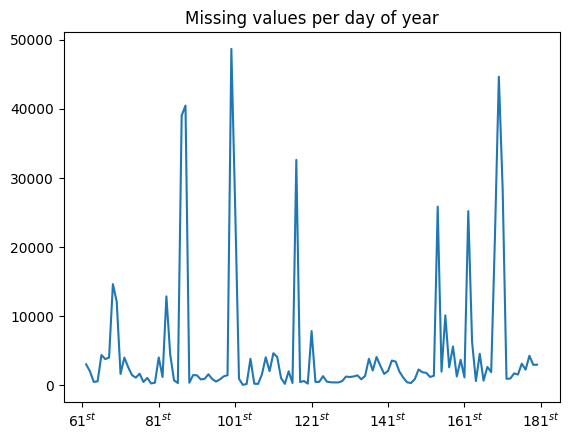

In [54]:
grouped = grouped_by_day_of_the_year.groupby(grouped_by_day_of_the_year.index.dayofyear)
res = grouped.sum()
res = res.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Missing values per day of year')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\3538780754.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


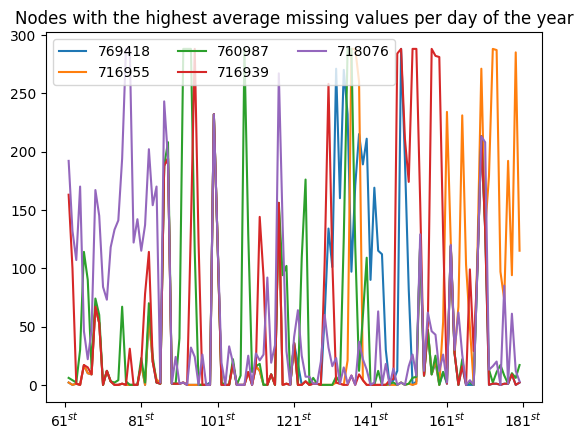

In [55]:
grouped = grouped_by_day_of_the_year.groupby(
    grouped_by_day_of_the_year.index.dayofyear)
grouped = grouped.sum()
higest_missing_values_nodes = grouped.mean(axis=0).sort_values()[-5:]
res = grouped[higest_missing_values_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Nodes with the highest average missing values per day of the year')
plt.legend(ncols=3)
plt.show()

In [56]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(higest_missing_values_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [36, 39, 56, 105, 174], 'columns': ['sensor_id', 'latitude', 'longitude'],…

# Average Speed Per-Node

In [57]:
import numpy as np

avg_speed_per_node = {}

node_values_df_with_nan = node_values_df.replace(0, np.NaN)

for c in node_values_df_with_nan.columns:
    avg_speed = node_values_df_with_nan[c].mean(skipna=True)
    avg_speed_per_node[c] = avg_speed

In [58]:
locations_df_with_avg_speed = locations_df.copy()
locations_df_with_avg_speed['Average speed'] = locations_df_with_avg_speed.apply(
    lambda x: avg_speed_per_node[x[0]], axis = 1
)


In [59]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'avg-speed-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [60]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=locations_df_with_avg_speed, name='Metr-LA average speed per node')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


From the map we can see that the highest average speed per node is observed in the northern east area of Los Angeles, which corresponds to Glendale. Lower average speeds are observed in the center of Los Angeles and in the western areas.

In [61]:
print('Metr-LA average speed per node:')
kepler_map

Metr-LA average speed per node:


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'z1982s8', 'type': …

In [62]:
import matplotlib.pyplot as plt
import numpy as np

In [63]:
days = { 0: 'Mon', 1: 'Tues', 2: 'Weds', 3: 'Thurs', 4: 'Fri', 5: 'Sat',
        6: 'Sun' }

In [64]:
# Get the average speed per timestamp.
node_speed_with_nans = node_values_df.replace(0, np.NaN)

In [65]:
from src.data.data_analysis import group_dataframe_by_period

grouped_by_day_of_week = group_dataframe_by_period(
    node_speed_with_nans, 'day_of_week', aggregation='mean')

In [66]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_day_of_week, locations_df, metric_name='Average speed',
    turn_datetimes_to_timestamp=False)

In [67]:
import json
with open(os.path.join(BASE_CONFIG_DIR, 'avg-speed-day-of-week.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [68]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average average speed per node per day of the week')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [69]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average average spe…

The average speed is generally high among each day of the week, ranging from $90$ to $100$ km/h. The lowest average speeds are experienced on weekdays, with an exception of monday. Higher average speed values are present in the weekends, probably indicating a general lower traffic flow.

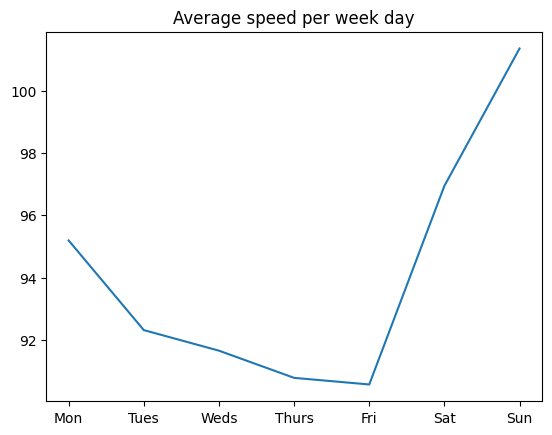

In [70]:
res = grouped_by_day_of_week.mean(axis=1, skipna=True)
f, ax = plt.subplots()
ax.plot(res.index.map(days), res.values)
#ax.set_xticks(res.index.strftime('%Y-%m-%d')[::25])
ax.set_title('Average speed per week day')
plt.show()

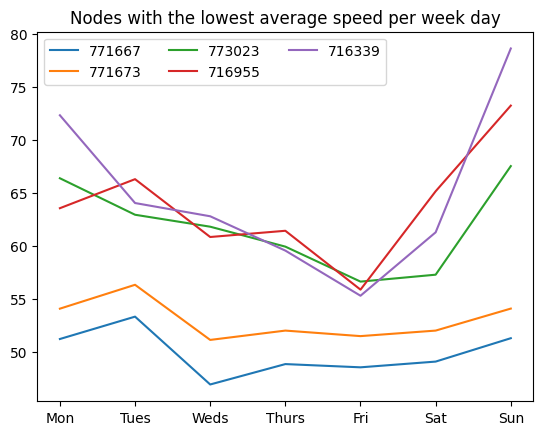

In [71]:
lowest_speed_nodes = grouped_by_day_of_week.mean(axis=0).sort_values()[:5]
res = grouped_by_day_of_week[lowest_speed_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index.map(days), res.values, label=res.columns.values)
#ax.set_xticks(res.index.strftime('%Y-%m-%d')[::25])
ax.set_title('Nodes with the lowest average speed per week day')
plt.legend(ncol=3)
plt.show()

The nodes experiencing the lowest average speed are observed in central areas of Los Angeles. These nodes are the same across all evaluations of average speed.

In [72]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(lowest_speed_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 16, 56, 91, 196], 'columns': ['sensor_id', 'latitude', 'longitude'], …

In [73]:
from src.data.data_analysis import group_dataframe_by_period

grouped_by_hour_of_day = group_dataframe_by_period(
    node_speed_with_nans, 'hour_of_day', aggregation='mean')

In [74]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_hour_of_day, locations_df, metric_name='Average speed',
    turn_datetimes_to_timestamp=False)

In [75]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'avg-speed-hour-of-day.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [76]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average missing values per node per hour of the day')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [77]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average missing val…

Regarding the average speed per hour, we can observe two troughs at the rush hours of $08:00$ a.m. and $05:00$ p.m.. These correspond to hours where people move to and come back from work respectively and where traffic flow may be higher.

The highest speed values are expectedly observed at night hours, where the traffic flow is supposedly not particularly intense.

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\2282825890.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])


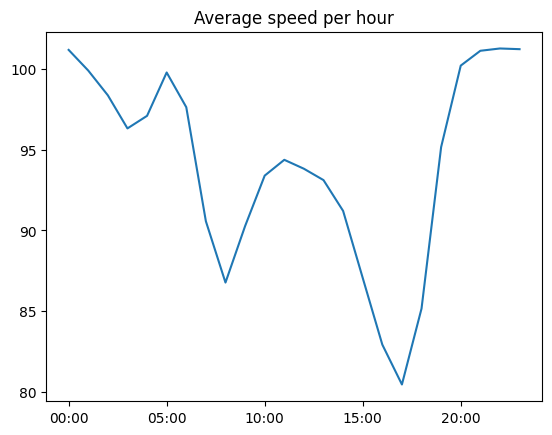

In [78]:
res = grouped_by_hour_of_day.mean(axis=1, skipna=True)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])
ax.set_title('Average speed per hour')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\3178881570.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])


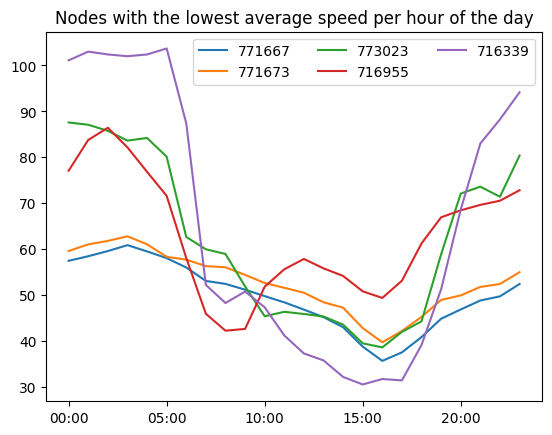

In [79]:
lowest_speed_nodes = grouped_by_hour_of_day.mean(axis=0).sort_values()[:5]
res = grouped_by_hour_of_day[lowest_speed_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])
ax.set_title('Nodes with the lowest average speed per hour of the day')
plt.legend(ncol=3)
plt.show()

In [80]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(lowest_speed_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 16, 56, 91, 196], 'columns': ['sensor_id', 'latitude', 'longitude'], …

In [81]:
grouped_by_week_of_the_year = group_dataframe_by_period(
    node_speed_with_nans, 'week_of_year', aggregation='mean')

In [82]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_week_of_the_year, locations_df, metric_name='Average speed',
    turn_datetimes_to_timestamp=True)

In [83]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'avg-speed-week-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [84]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average speed per node per week of the year')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [85]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average speed per n…

The chart regarding the average speed per day is erratic, but generally presenting speeds in the range of $90$ to $96$ km/h. The chart peaks in March and plummets in the beginning of June.

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\2290813204.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


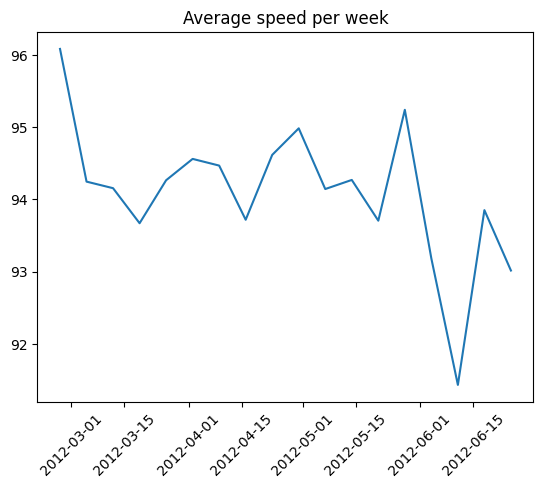

In [90]:
#grouped = grouped_by_week_of_the_year.sum()
grouped = grouped_by_week_of_the_year.groupby(
    grouped_by_week_of_the_year.index.to_timestamp())
grouped = grouped.mean()
res = grouped.mean(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Average speed per week')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\702136061.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


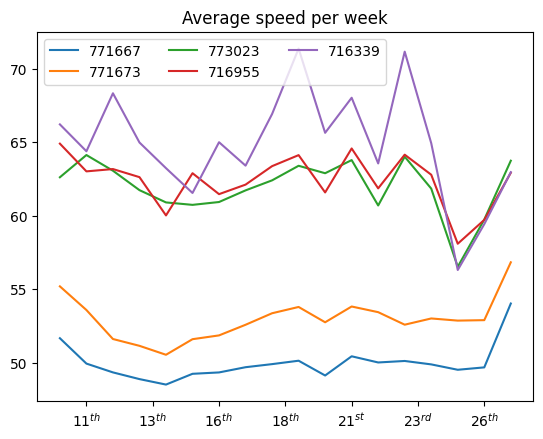

In [91]:
grouped = grouped_by_week_of_the_year.groupby(
    grouped_by_week_of_the_year.to_timestamp().index.isocalendar().week.to_list())
grouped = grouped.mean()
lowest_speed_nodes = grouped.mean(axis=0).sort_values()[:5]
res = grouped[lowest_speed_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Average speed per week')
plt.legend(ncols=3)
plt.show()

In [92]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(lowest_speed_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 16, 56, 91, 196], 'columns': ['sensor_id', 'latitude', 'longitude'], …

In [93]:
grouped_by_day_of_the_year = group_dataframe_by_period(
    node_speed_with_nans, 'day_of_year', aggregation='mean')

In [94]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_day_of_the_year, locations_df, metric_name='Average speed',
    turn_datetimes_to_timestamp=True)

In [95]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'avg-speed-day-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [96]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average speed per node per day of the year')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\riccardo\AppData\Roaming\Python\Python310\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [97]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average speed per n…

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\4204229560.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


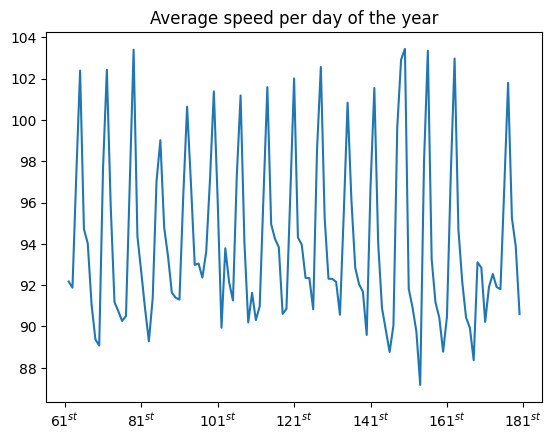

In [98]:
#grouped = grouped_by_week_of_the_year.sum()
grouped = grouped_by_day_of_the_year.groupby(
    grouped_by_day_of_the_year.to_timestamp().index.dayofyear)
res = grouped.mean()
res = res.mean(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Average speed per day of the year')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\4001660213.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


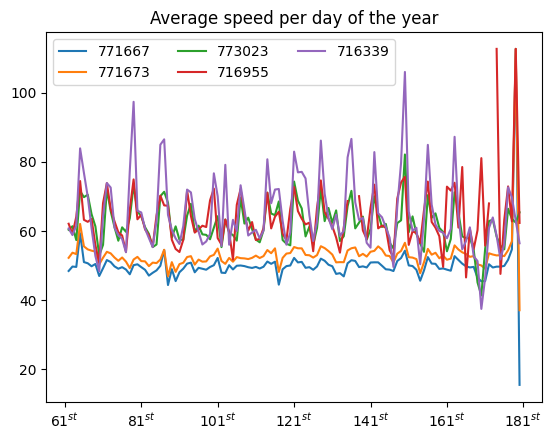

In [99]:
grouped = grouped_by_day_of_the_year.groupby(
    grouped_by_day_of_the_year.to_timestamp().index.dayofyear)
grouped = grouped.mean()
lowest_speed_nodes = grouped.mean(axis=0).sort_values()[:5]
res = grouped[lowest_speed_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Average speed per day of the year')
plt.legend(ncols=3)
plt.show()

In [100]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(lowest_speed_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 16, 56, 91, 196], 'columns': ['sensor_id', 'latitude', 'longitude'], …

# With the most bottlenecks

In [101]:
all_node_values = node_values_df.to_numpy().ravel()
all_node_values = all_node_values[all_node_values > 0]

In [102]:
percentile = .05

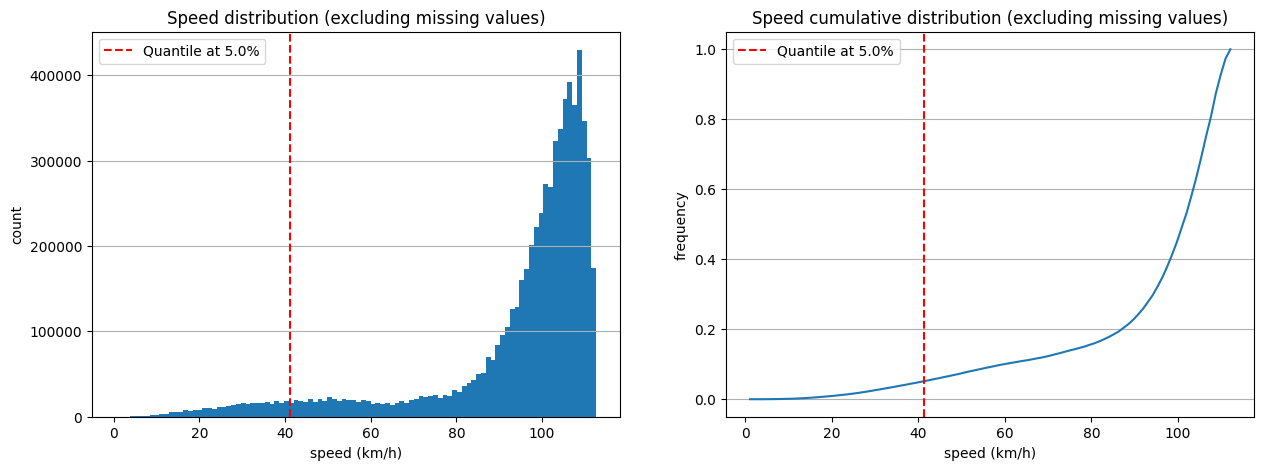

In [103]:
if percentile is not None:
    quantile = np.quantile(all_node_values, percentile)
else:
    quantile = None


hist, bin_edges = np.histogram(all_node_values, bins=100, range=None,
                               density=None, weights=None)

width = bin_edges[1] - bin_edges[0]
center = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(center, hist, width=width)
plt.xlabel('speed (km/h)')
plt.ylabel('count')
plt.title('Speed distribution (excluding missing values)')
plt.grid(axis='y')
if quantile is not None:
    plt.axvline(x = quantile, color = 'r', linestyle='--',
                label=f'Quantile at {percentile * 100}%')
plt.legend()

hist, bin_edges = np.histogram(all_node_values, bins=100, density=True)
cumsum = np.cumsum(hist) * (bin_edges[1] - bin_edges[0])
center = (bin_edges[:-1] + bin_edges[1:]) / 2

# Cumulative distribution
plt.subplot(1, 2, 2)
plt.plot(center, cumsum, '-')
plt.title('Speed cumulative distribution (excluding missing values)')
plt.xlabel('speed (km/h)')
plt.ylabel('frequency')
plt.grid(axis='y')
if quantile is not None:
    plt.axvline(x = quantile, color = 'r', linestyle='--',
                label=f'Quantile at {percentile * 100}%')
plt.legend()
plt.show()

In [104]:
quantile = np.quantile(all_node_values, percentile)

In [105]:
bottlenecks_per_node = {}

node_values_df_copy = node_values_df.copy()

for c in node_values_df_copy.columns:
    filtered_column = node_values_df_copy[c] < quantile
    filtered_column *= node_values_df_copy[c] > 0
    try:
        bottlenecks = filtered_column.value_counts()[True]
    except KeyError:
        bottlenecks = 0
    bottlenecks_per_node[c] = bottlenecks

In [106]:
locations_df_with_bottlenecks = locations_df.copy()
locations_df_with_bottlenecks[f'Bottlenecks below {quantile} km/h count'] = locations_df_with_bottlenecks.apply(
    lambda x: bottlenecks_per_node[x[0]], axis = 1
)


In [107]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'total-bottlenecks-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [108]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=locations_df_with_bottlenecks, name='Metr-LA bottlenecks per node')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


The map illustrates that the highest bottleneck cases are observed in the central area of Los Angeles and in the crossing of the highways in the west side of the map, which is a transit area to reach either Santa Clarita or Santa Monica.

In [109]:
print('Metr-LA bottlenecks per node:')
kepler_map

Metr-LA bottlenecks per node:


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'gqgqf6g', 'type': …

In [110]:
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}

In [111]:
import matplotlib.pyplot as plt


In [112]:
# Get the missing values count per timestamp.
bottlenecks = node_values_df.apply(lambda x: (x > 0) & (x < quantile))
bottlenecks.index = node_values_df.index

In [113]:
from src.data.data_analysis import group_dataframe_by_period

grouped_by_day_of_week = group_dataframe_by_period(
    bottlenecks, 'day_of_week', aggregation='sum')

In [114]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_day_of_week, locations_df, metric_name='Bottlenecks count',
    turn_datetimes_to_timestamp=False)

In [115]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'bottlenecks-day-of-week-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [116]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average missing values per node per day of the week')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [117]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average missing val…

Interestingly, the highest amount of bottlenecks is observed in the last weekdays, namely thursday and friday. Lowest bottleneck cases are experienced on Monday and in the weekend.

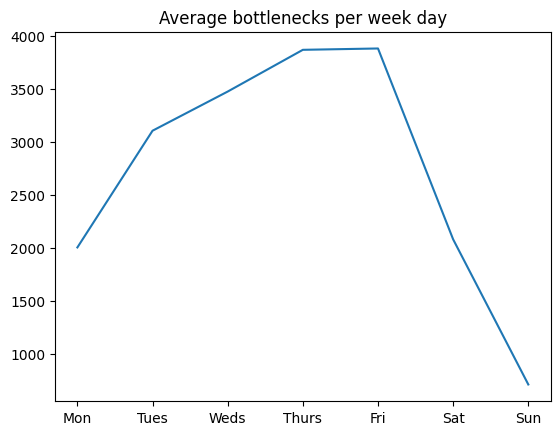

In [118]:
res = grouped_by_day_of_week.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index.map(days), res.values)
#ax.set_xticks(res.index.strftime('%Y-%m-%d')[::25])
ax.set_title('Average bottlenecks per week day')
plt.show()

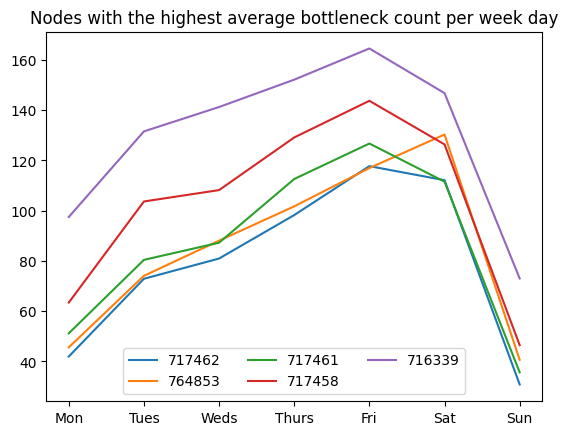

In [119]:
highest_bottlenecks_nodes = grouped_by_day_of_week.mean(axis=0).sort_values()[-5:]
res = grouped_by_day_of_week[highest_bottlenecks_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index.map(days), res.values, label=res.columns.values)
#ax.set_xticks(res.index.strftime('%Y-%m-%d')[::25])
ax.set_title('Nodes with the highest average bottleneck count per week day')
plt.legend(ncol=3)
plt.show()

The highest amount of bottlenecks is seen in the Bycicle District area in all evaluation cases.

In [120]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(highest_bottlenecks_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 144, 160, 163, 187], 'columns': ['sensor_id', 'latitude', 'longitude'…

In [121]:
from src.data.data_analysis import group_dataframe_by_period

grouped_by_hour_of_day = group_dataframe_by_period(
    bottlenecks, 'hour_of_day', aggregation='sum')

In [122]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_hour_of_day, locations_df, metric_name='Bottlenecks count',
    turn_datetimes_to_timestamp=False)

In [123]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'bottlenecks-hour-of-day-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [124]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average bottleneck counts per node per hour of the day')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [125]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average bottleneck …

The distribution of average bottlenecks per hour illustrates that the highest traffick bottlenecks are seen during rush hours: $08:00$ a.m. and $05:00$ p.m., with moderately high values still observed in the period in between. Expectedly, lowest amounts of bottlenecks happen at night.

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\3934042038.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])


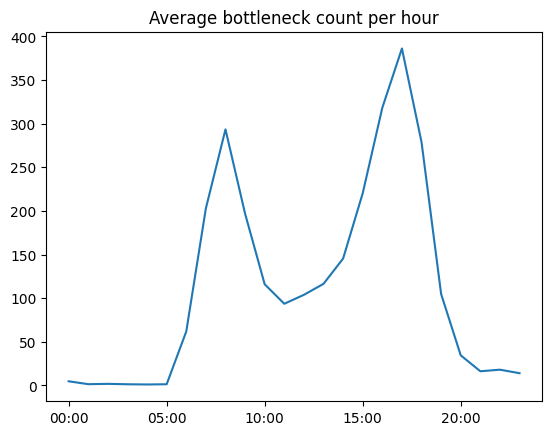

In [126]:
res = grouped_by_hour_of_day.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])
ax.set_title('Average bottleneck count per hour')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\1001871754.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])


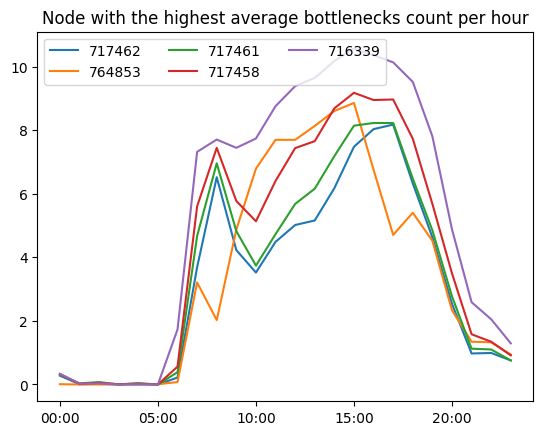

In [128]:
higest_bottleneck_nodes = grouped_by_hour_of_day.mean(axis=0).sort_values()[-5:]
res = grouped_by_hour_of_day[higest_bottleneck_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
ax.set_xticklabels([f'{int(t):02d}:00' for t in ax.get_xticks()])
ax.set_title('Node with the highest average bottlenecks count per hour')
plt.legend(ncol=3)
plt.show()

In [129]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(highest_bottlenecks_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 144, 160, 163, 187], 'columns': ['sensor_id', 'latitude', 'longitude'…

In [130]:
grouped_by_week_of_the_year = group_dataframe_by_period(
    bottlenecks, 'week_of_year', aggregation='sum')

In [131]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_week_of_the_year, locations_df, metric_name='Bottlenecks count',
    turn_datetimes_to_timestamp=True)

In [132]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'bottlenecks-week-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [133]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average bottleneck count per node per week of the year')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [134]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average bottleneck …

The bottleneck distribution is erratic during the weeks, but highest values are generally observed during the first weeks of the months.

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\26030674.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


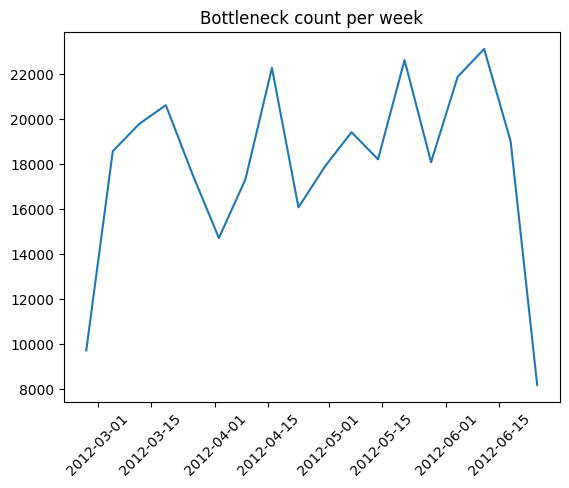

In [135]:
#grouped = grouped_by_week_of_the_year.sum()
grouped = grouped_by_week_of_the_year.groupby(
    grouped_by_week_of_the_year.index.to_timestamp())
grouped = grouped.sum()
res = grouped.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Bottleneck count per week')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\4013950675.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


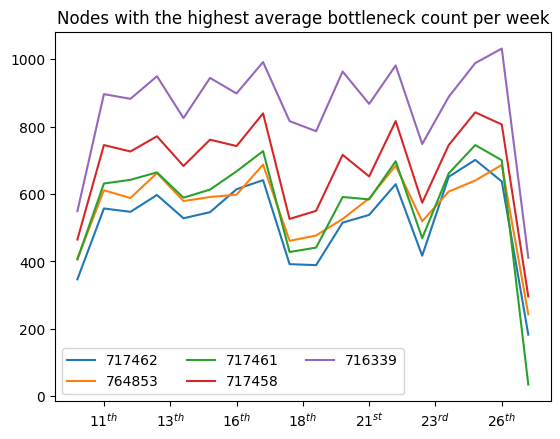

In [136]:
grouped = grouped_by_week_of_the_year.groupby(
    grouped_by_week_of_the_year.to_timestamp().index.isocalendar().week.to_list())
grouped = grouped.sum()
higest_missing_values_nodes = grouped.mean(axis=0).sort_values()[-5:]
res = grouped[higest_missing_values_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Nodes with the highest average bottleneck count per week')
plt.legend(ncols=3)
plt.show()

In [137]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(highest_bottlenecks_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 144, 160, 163, 187], 'columns': ['sensor_id', 'latitude', 'longitude'…

In [138]:
grouped_by_day_of_the_year = group_dataframe_by_period(
    bottlenecks, 'day_of_year', aggregation='sum')

In [139]:
from src.data.data_analysis import get_node_values_with_location_dataframe

node_values_location_df = get_node_values_with_location_dataframe(
    grouped_by_day_of_the_year, locations_df, metric_name='Bottlenecks count',
    turn_datetimes_to_timestamp=True)

In [140]:
import json

with open(os.path.join(BASE_CONFIG_DIR, 'bottlenecks-day-map.json'), 'r') as f:
    kepler_map_config = json.load(f)

In [141]:
kepler_map = KeplerGl(height=800, config=kepler_map_config)

kepler_map.add_data(data=node_values_location_df,
                    name='Metr-LA average bottleneck count per node per day of the year')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [142]:
kepler_map

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['Metr-LA average bottleneck …

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\3895628774.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


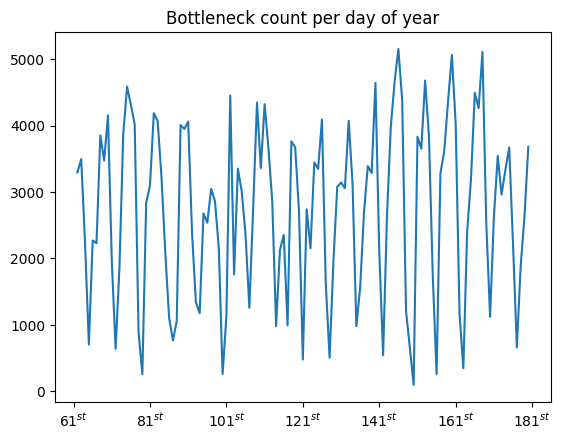

In [143]:
grouped = grouped_by_day_of_the_year.groupby(grouped_by_day_of_the_year.index.dayofyear)
res = grouped.sum()
res = res.sum(axis=1)
f, ax = plt.subplots()
ax.plot(res.index, res.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Bottleneck count per day of year')
plt.show()

C:\Users\riccardo\AppData\Local\Temp\ipykernel_16300\1060341445.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(format_week, ax.get_xticks()))


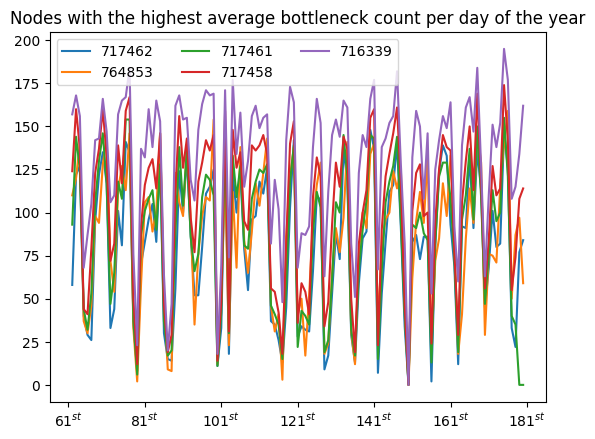

In [144]:
grouped = grouped_by_day_of_the_year.groupby(
    grouped_by_day_of_the_year.index.dayofyear)
grouped = grouped.sum()
higest_missing_values_nodes = grouped.mean(axis=0).sort_values()[-5:]
res = grouped[higest_missing_values_nodes.index.values]
f, ax = plt.subplots()
ax.plot(res.index, res.values, label=res.columns.values)
def format_week(week: float):
    date_suffix = [r'$^{th}$', r'$^{st}$', r'$^{nd}$', r'$^{rd}$']
    str_week = int(week) + 1
    if str_week % 10 in [1, 2, 3] and str_week % 100 not in [11, 12, 13]:
        return str(str_week) + date_suffix[str_week % 10]
    else:
        return str(str_week) + date_suffix[0]
ax.set_xticklabels(map(format_week, ax.get_xticks()))
ax.set_title('Nodes with the highest average bottleneck count per day of the year')
plt.legend(ncols=3)
plt.show()

In [146]:
kepler_map = KeplerGl(height=800)

kepler_map.add_data(data=locations_df[locations_df['sensor_id'].isin(higest_missing_values_nodes.index)])
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [12, 144, 160, 163, 187], 'columns': ['sensor_id', 'latitude', 'longitude'…